In [75]:
%load_ext autoreload
%autoreload 2

import os
import cv2
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from attention.img_proc.img_process import *
from attention.img_proc.img_split import *
from attention.models.face_models import *
from attention.utils.img_plot import *
from attention.utils.utilities import *
from attention.utils.output_plot import *
from attention.params import *
import copy

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [76]:
# Get attention_data directory
current_directory = os.getcwd()
data_directory = os.path.join(current_directory, os.pardir, "attention_data")

## Creating the frames

### Option 1: from video

In [77]:
# video_folder_path = os.path.join(data_directory, "video")
# video_name = "video2.MOV"
# video_path = os.path.join(video_folder_path, video_name)
# frames = extract_video_frames(video_path, 
#                               period_sec=1,
#                               start_sec=35, end_sec=185)

# # Saving the frames
# image_folder_path = os.path.join(data_directory, "frames")
# for timestamp, frame in frames.items():
#     frame_name = video_name.split('.')[0] + f'_ds{int(timestamp * 10):05}'
#     save_image(frame, frame_name + '.png', image_folder_path)

### Option 2: from photos

In [78]:
image_folder_path = os.path.join(data_directory, "frames")
for idx, filename in enumerate(sorted(os.listdir(image_folder_path))):
    os.rename(os.path.join(image_folder_path, filename), os.path.join(image_folder_path, f'frame_ds{idx * 10:05}.png'))

## Training the face recognition model

In [79]:
# # Training the face recognition model
# known_folder_path = os.path.join(data_directory, os.pardir, "attention_known_faces")
# known_paths = load_image_paths(known_folder_path)
# known_names = list(known_paths.keys())
# known_faces = [read_image(image_path) for image_path in known_paths.values()]
# known_encodings = train_faces(known_faces, known_names)

## Running the program

In [80]:
# PARAMS:
n_split_w = 6
n_split_h = 6
landmark_idx = LEFT_EYE_EDGES  + LEFT_IRIS_CENTER + RIGHT_EYE_EDGES + RIGHT_IRIS_CENTER

# Dataframe columns
df_columns =  ['frame',
'timestamp',
'face_idx',
'recognition_prediction',
'recognition_distance',
'attentive',
'left_prediction',
'left_score',
'right_prediction',
'right_score',
'head_direction_prediction',
'head_direction_score',
'head_inclination_prediction',
'head_inclination_score']

In [81]:
image_folder_path = os.path.join(data_directory, "frames")
image_paths = load_image_paths(image_folder_path)

attention_df = pd.DataFrame(columns=df_columns) 

for image_name, image_path in image_paths.items():
    
    # Loading image
    image = read_image(image_path)
    timestamp = int(image_name.split('_ds')[1]) if '_ds' in image_name else np.nan
    image_summary, ratio_summary = resize_image(image, 1920)
    # Splitting image
    crops = split_image(image, n_split_w, n_split_h, 0.05, 0.05)
    # Generating bboxes for each crop
    bbox_crop_list = []
    bbox_crop_list_absolute = []
    for crop in crops:
        coord_set = detect_face(crop.image)
        bbox_crop_list.append(coord_set)
        coord_set_absolute = reconstruct_coord(crop, coord_set)
        bbox_crop_list_absolute.append(coord_set_absolute)
    bbox_crop_list_absolute
    # Eliminating duplicates bboxes
    bbox_list = bbox_merge(bbox_crop_list_absolute, intersect_threshold=0.6)
    # # Drawing the unique bboxes on the original image
    # image_output = annotate_bboxes(image, bbox_list)
    # # Saving the image with its bboxes
    # bbox_path = os.path.join(data_directory, "output_bbox")
    # save_image(image_output, image_name + '.png', bbox_path)
    
    # Generating face crops
    faces = crop_faces(image, bbox_list)
    # # Saving face crops
    # face_path = os.path.join(data_directory, "face_crops")
    # for face_idx, face in enumerate(faces):
    #     face_name = image_name + f'_{face_idx}'
    #     save_image(face, face_name + '.png', face_path)
    
    # Generating eye and iris landmarks
    for face_idx, face in enumerate(faces):
        
        face_name = image_name + f'_{face_idx}'
        mp_landmarks = find_landmarks(face)
        if mp_landmarks:                # Only run attention/ recognition if it detects a face
            # Converting the Mediapipe landmark to a standard system of coordinates
            landmark_list = convert_landmarks(face, mp_landmarks)
            # # Drawing the face mesh on the face
            # face_mesh = annotate_mesh(face, mp_landmarks)
            # # Saving face with complete mesh
            # mesh_path = os.path.join(data_directory, "output_mesh")
            # save_image(face_mesh, face_name + '.png', mesh_path)
            
            # Detecting eye direction and attention
            face_name = image_name + f'_{face_idx}'
            eye_directions = detect_eye_directions(landmark_list, extreme_threshold = 0.63, detailed_threshold_main = 0.6, detailed_threshold_comp = 0.45)
            eye_inclinations = detect_eye_inclinations(landmark_list, threshold = 0.23)
            head_direction = detect_head_direction(landmark_list, left_threshold = 0.35, right_threshold = 1)
            head_inclination = detect_head_inclination(landmark_list, down_threshold = 2.3)
            attention, attention_driver = is_attentive(eye_directions, eye_inclinations, head_direction, head_inclination)
            # Drawing iris landmarks + annotating attention results on original image
            prediction_lefteye_direction, score_lefteye_direction = eye_directions['left']
            prediction_righteye_direction, score_righteye_direction = eye_directions['right']
            prediction_lefteye_inclination, score_lefteye_inclination = eye_inclinations['left']
            prediction_righteye_inclination, score_righteye_inclination = eye_inclinations['right']
            prediction_head_direction, score_head_direction = head_direction
            prediction_head_inclination, score_head_inclination = head_inclination
            prediction_attention = 'attentive' if attention else 'inattentive'
            # face_attention = annotate_attention(face, landmark_list, 
            #                                         prediction_lefteye_direction, score_lefteye_direction, 
            #                                         prediction_righteye_direction, score_righteye_direction,
            #                                         prediction_lefteye_inclination, score_lefteye_inclination, 
            #                                         prediction_righteye_inclination, score_righteye_inclination,
            #                                         prediction_head_direction, score_head_direction,
            #                                         prediction_head_inclination, score_head_inclination,
            #                                         prediction_attention)
            # # Saving attention image output
            # attention_path = os.path.join(data_directory, "output_attention")
            # save_image(face_attention, face_name + '.png', attention_path)
        
        
            # Recognizing a face
            face_name = image_name + f'_{face_idx}'
            face_prediction = recognize_face(face, known_encodings)
            # Annotating name and distance on the face image
            prediction_recognition, distance_recognition = face_prediction
            # face_recognition = annotate_recognition(face, prediction_recognition, distance_recognition)
            # # Saving recognition image output
            # recognition_path = os.path.join(data_directory, "output_recognition")
            # save_image(face_recognition, face_name + '.png', recognition_path)
            
            
            # Generating summary image
            # Annotating with key info (bbox, attentiveness, recognition)
            recognition = False if pd.isna(prediction_recognition) else True
            bbox_face = bbox_list[face_idx]
            image_summary = annotate_summary(image_summary, ratio_summary, 
                                             bbox_face, 
                                             attention, attention_driver, 
                                             recognition)
            
            
            # Saving data in the dataframe
            attention_df.loc[len(attention_df)] = [image_name,
                                                    timestamp,
                                                    face_idx,
                                                    prediction_recognition, distance_recognition,
                                                    attention,
                                                    prediction_lefteye_direction, score_lefteye_direction,
                                                    prediction_righteye_direction, score_righteye_direction,
                                                    prediction_head_direction, score_head_direction,
                                                    prediction_head_inclination, score_head_inclination]
                
        
        # Saving summary image once all faces done
        summary_path = os.path.join(data_directory, "output_summary")
        save_image(image_summary, image_name + '.png', summary_path)
    

error: OpenCV(4.7.0) /Users/xperience/GHA-OCV-Python/_work/opencv-python/opencv-python/opencv/modules/imgproc/src/color.cpp:182: error: (-215:Assertion failed) !_src.empty() in function 'cvtColor'


## Saving the dataframe

In [82]:
# Grouping the timestamps
attention_df = attention_df.sort_values(by=['timestamp', 'face_idx']).reset_index(drop=True)
grouping_factor = 10
timestamps = attention_df["timestamp"].unique()
timestamp_dict = {timestamps[i]: timestamps[i - i % grouping_factor] for i in range(len(timestamps))}
time_group = attention_df['timestamp'].map(timestamp_dict)
attention_df.insert(2, 'time_group', time_group)


In [83]:
attention_df.to_csv(os.path.join(data_directory,'attention_output.csv'), index=False)
# attention_df = pd.read_csv(os.path.join(data_directory, 'attention_output.csv')).sort_values(by=['timestamp', 'face_idx']).reset_index(drop=True)

## Showing the results

In [84]:
roll = 10
fig = plot_attention_curve(attention_df, roll)
fig.show()

In [85]:
def average_nan(s: pd.Series, threshold: float = 0.4):
    na_rate = s.isna().sum() / len(s)
    return s.mean().round(2) if na_rate <= threshold else np.nan

<Axes: xlabel='time_group'>

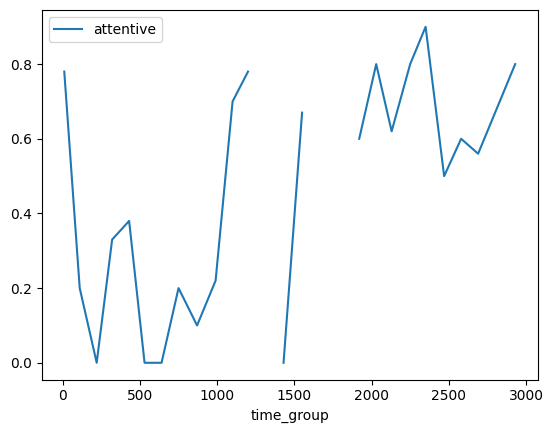

In [86]:
target_person = 'Gonzalo'

person_mask = attention_df['recognition_prediction'] == target_person

# Creating a dataframe with all timestamps available even if person is not recognized
time_df = attention_df[['timestamp', 'time_group']].drop_duplicates()
person_filter_df = attention_df[person_mask].drop(columns='time_group')
person_df = pd.merge(time_df, person_filter_df, how='left', on='timestamp').set_index('timestamp')

person_attention_sec = person_df[['time_group', 'attentive']] * 1

person_attention_block = person_attention_sec.groupby('time_group').agg(
    {'attentive': lambda s: average_nan(s, 0.3)}) 

person_attention_block.plot()